In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from pandas.plotting import scatter_matrix

np.random.seed(42)

In [2]:
# 1) 예시 데이터 생성

n = 150
X = pd.DataFrame({
    "X1" : np.random.normal(0, 1, n),
    "X2" : np.random.normal(0, 1, n),
    "X3" : np.random.uniform(-2, 2, n),
    "X4" : np.random.normal(0, 1, n)
})
beta = np.array([3.0, -2.0, 1.5, 0.0])  # 진짜 계수 설정 (절편은 제외)
intercept = 5.0  # 절편
eps = np.random.normal(0, 1.2, n)  # 오차
y = intercept + X.values @ beta + eps  # @ : np.dot()
df = X.copy()
df["Y"] = y

In [3]:
# 2) OLS 적합

X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
fitted = model.fittedvalues  # y_hat
resid = model.resid  # 잔차

# 잔차 관련 값들
influence = model.get_influence()
hat = influence.hat_matrix_diag  # 레버리지
sigma2 = np.sum(resid**2) / (n - X_with_const.shape[1])  # 추정 분산오차
stud_resid_internal = resid / np.sqrt(sigma2) * np.sqrt(1 - hat)  # 내적 표준화 잔차
cooks_d = influence.cooks_distance[0]

# Hadi 영향력 측도
ri2 = stud_resid_internal**2
hadi = (hat / (1-hat)) * (ri2 / np.maximum(1e-12, (1 - ri2)))

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     376.7
Date:                Wed, 15 Oct 2025   Prob (F-statistic):           1.67e-75
Time:                        06:52:54   Log-Likelihood:                -243.52
No. Observations:                 150   AIC:                             497.0
Df Residuals:                     145   BIC:                             512.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0154      0.104     48.088      0.0

### **OLS 회귀 가정 확인**

In [14]:
# 임계값들 empirical rule

p = X_with_const.shape[1] - 1  # 절편 제외 예측변수 수
lev_threshold = 2 * (p + 1) / n  # 평균의 약 2배로 high leverage의 경험적 기준
cooks_threshold = 4 / n  # 높은 Cook's Distance의 경험적 기준

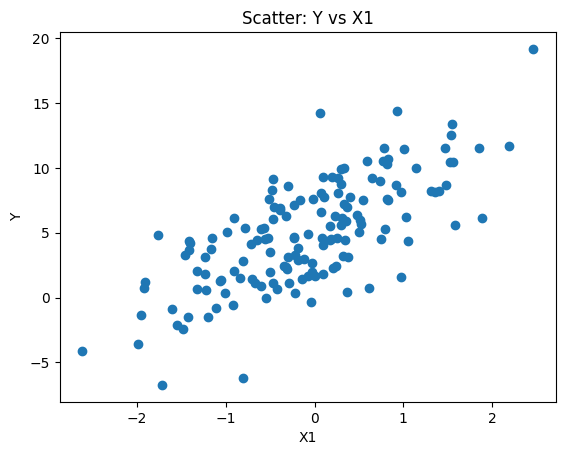

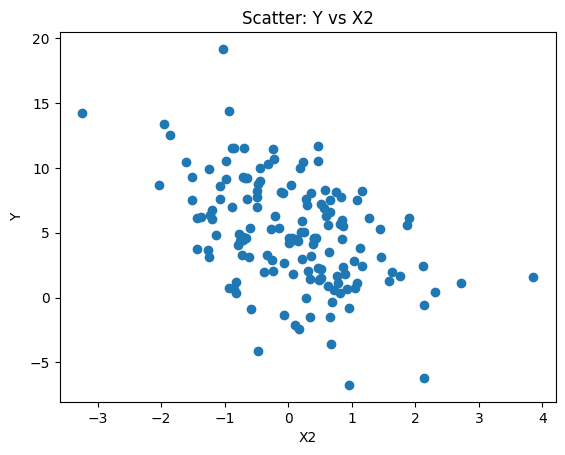

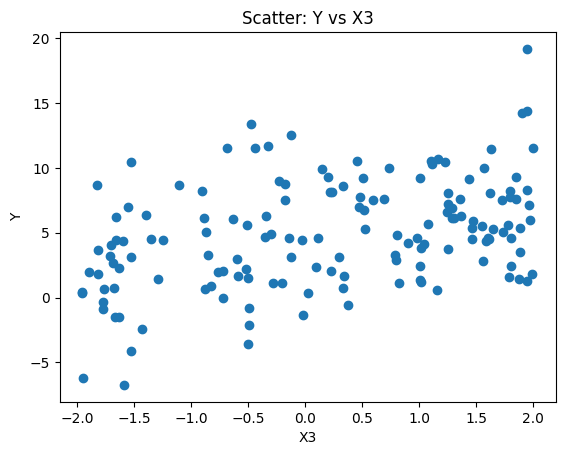

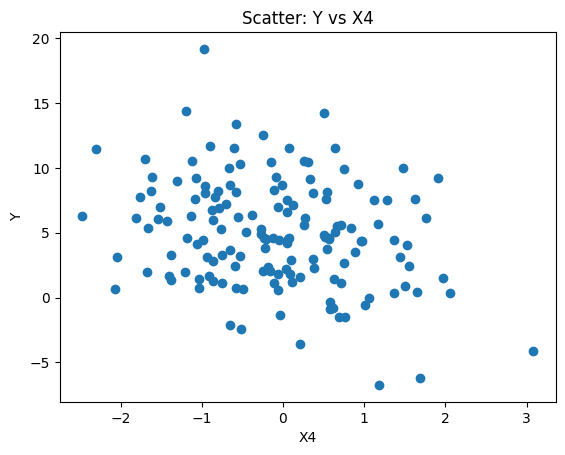

In [6]:
# 3) 그래프 확인

# =======================================================
# (1) Y 대 각 Xj의 산점도
'''
- X와 Y의 선형적 관계 확인 가능
- 이상치 대략적 탐색 가능
'''
# =======================================================

for col in X.columns:
  plt.figure()
  plt.scatter(df[col], df["Y"])
  plt.xlabel(col)
  plt.ylabel("Y")
  plt.title(f"Scatter: Y vs {col}")
  plt.show()

<Figure size 640x480 with 0 Axes>

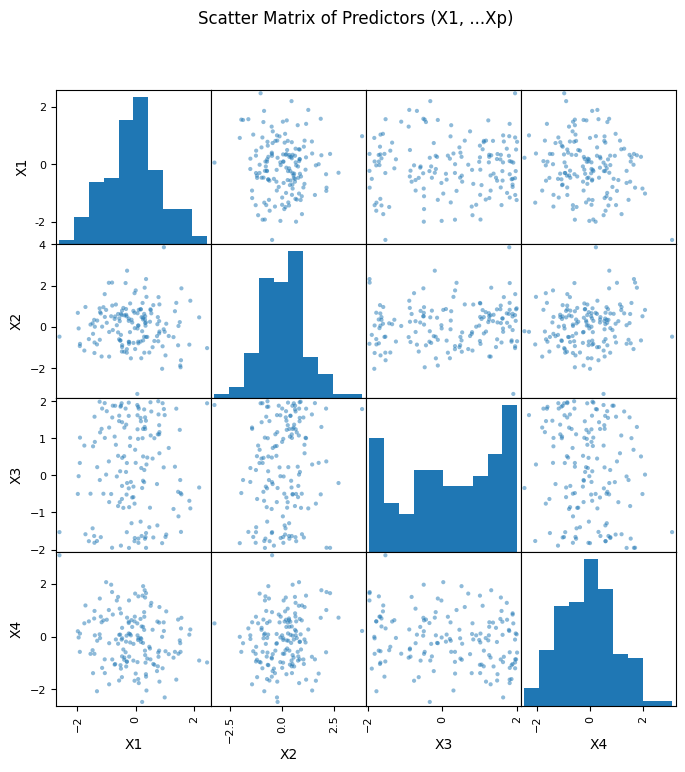

In [7]:
# =======================================================
# (2) X들의 산점도 행렬
'''
- 예측변수들 간 선형독립성(다중공선성) 확인 가능
- 선형적 패턴이 없어야 함
'''
# =======================================================

plt.figure()
scatter_matrix(X, figsize=(8,8))
plt.suptitle("Scatter Matrix of Predictors (X1, ...Xp)")
plt.show()

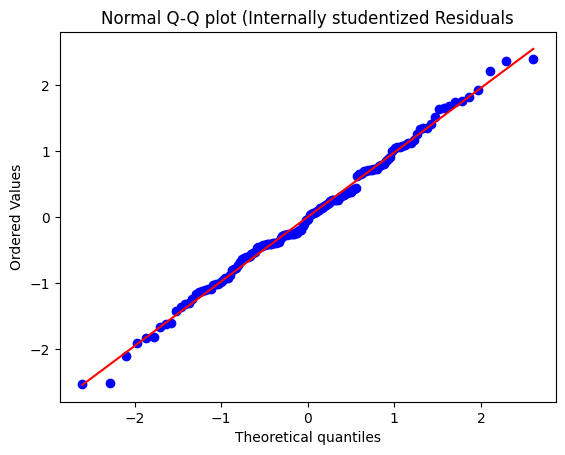

In [8]:
# =======================================================
# (3) 내적 표준화 잔차의 정규확률(Q-Q) 플롯
'''
- 오차 정규성 가정 확인
'''
# =======================================================

plt.figure()
stats.probplot(stud_resid_internal, dist="norm", plot=plt)
plt.title("Normal Q-Q plot (Internally studentized Residuals")
plt.show()

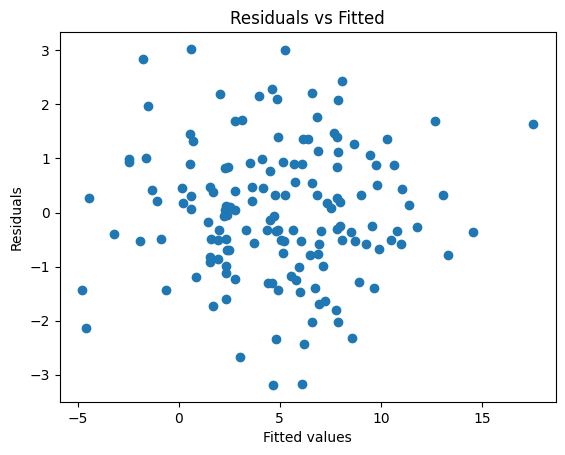

In [10]:
# =======================================================
# (4) 잔차 대 적합값 플롯 (residuals vs fitted)
'''
- 잔차가 패턴을 보이는지 확인
- 잔차가 랜덤하게 나타나야 함
'''
# =======================================================

plt.figure()
plt.scatter(fitted, resid)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

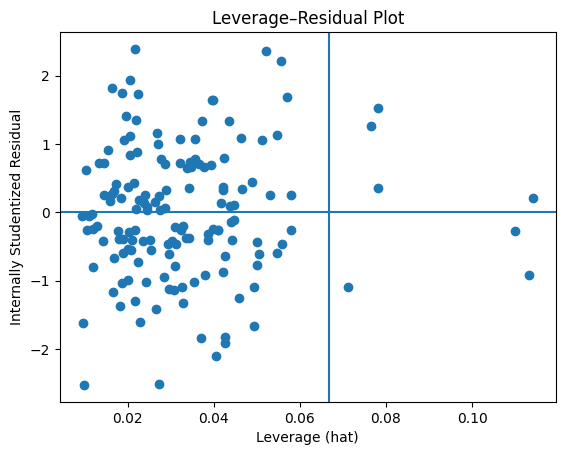

In [17]:
# =======================================================
# (5) 래버리지-잔차 플롯 (Leverage-Residual plot)
'''
- 큰 레버리지와 큰 잔차 점을 동시에 탐지
- 영향점 후보 파악
'''
# =======================================================

plt.figure()
plt.scatter(hat, stud_resid_internal)
plt.axvline(lev_threshold)  # 레버리지 임계(관례)
plt.axhline(0)
plt.xlabel("Leverage (hat)")
plt.ylabel("Internally Studentized Residual")
plt.title("Leverage–Residual Plot")
plt.show()

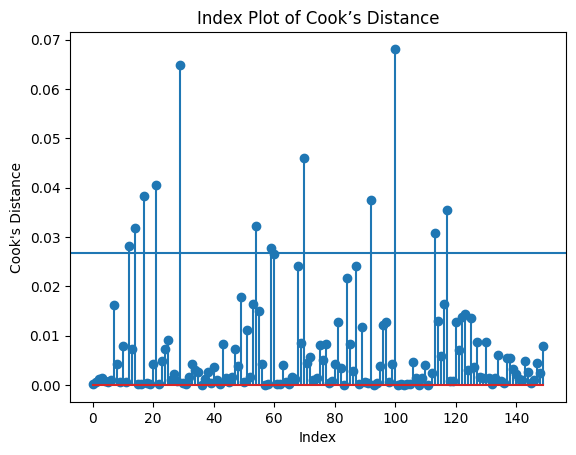

In [19]:
# =======================================================
# (6) Cook’s Distance 인덱스 플롯
'''
- 영향점 확인
'''
# =======================================================

plt.figure()
plt.stem(np.arange(n), cooks_d)
plt.axhline(cooks_threshold)
plt.xlabel("Index")
plt.ylabel("Cook's Distance")
plt.title("Index Plot of Cook’s Distance")
plt.show()

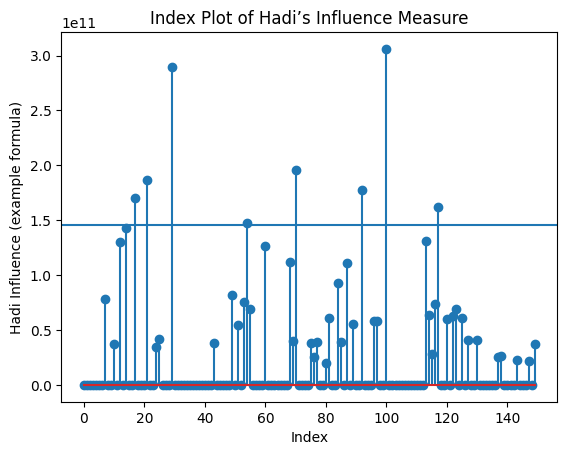

In [20]:
# =======================================================
# (7) Hadi 영향력 인덱스 플롯
'''
- 영향점 확인
'''
# =======================================================

plt.figure()
plt.stem(np.arange(n), hadi)
thr_hadi = np.quantile(hadi, 0.95)  # 95% 분위수 참고선
plt.axhline(thr_hadi)
plt.xlabel("Index")
plt.ylabel("Hadi Influence (example formula)")
plt.title("Index Plot of Hadi’s Influence Measure")
plt.show()